# CUSTOMER CHURN IN TELECOMMUNICATION COMPANY

## Project overview

Customer churn is the loss of clients or customers. Predicting churn helps the Telecom company to:

1. Identify at risk customers and implement *highly targeted* efforts to stop them churning.
2. Identify pain points and friction across a customers journey.
3. Identify strategies that target these pain points to lower churn and increase retention rates.



## Business understanding

### Business problem

### Objectives

- To build a machine learning model that can accurately predict customers  who will churn based on the information available in the dataset.<br>
- To identify the features that are important for predicting customer churn.

### Success criteria

The most important metric that will be used to evaluate the performance of the classification algorithm is recall. Recall involves the rate at which the model correctly predicts customers who are going to churn. The end goal is to minimize false negatives. Failure to identify a customer who is about to churn is more costly to the business, than wrongly classifying a non-churning customer. A successful model should have a recall of at least 85%.<br>
However, if the model predicts that all customers will churn, it would have a perfect recall. This would not be useful to the business since it is clear that not all customers will churn. It will be important to keep track of precision and accuracy as secondary metrics.

# Data Understanding

In [94]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


# sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE


In [95]:
# loading the dataset
df = pd.read_csv('Telecom_data.csv')

# Data Understanding

In [96]:
# Displaying the first 5 rows of the data to get a representation of how the columns look like
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [97]:
#Number of columns and rows of the dataset
print("There are %d rows and %d columns in the dataset." %df.shape)

There are 3333 rows and 21 columns in the dataset.


In [98]:
# A function that checks for datatypes within the dataframe
def check_data_types(dataframe):
    data_types = dataframe.dtypes
    print(data_types)

In [99]:
check_data_types(df)

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object


In [100]:
# Number of States
print("There are", df["state"].nunique(), "unique entries in the state Column, representing the number of states")

There are 51 unique entries in the state Column, representing the number of states


From the table above, the information above, the columns "state", "international plan", "voice mail plan" and "churn" have string values. 

The last three have values 'yes' and 'no' and are converted to 1 and 0 respectively to allow for numerical analysis 

The column "state" contains categorical data. For this column, there are two options of dealing with these values: 
1. Using One-hot encoding.
2. Using LabelEncoder.

LabelEncoder was selected to replace each unique State with a unique integer. It was selected over One-hot encoding as there are 51 unique values that would increase the number of columns, causing the dataset to be messy and would affect the analysis of the importance of features in the models.


## The Target Variable

The target variable is "churn". This project seeks to compare the effects of the different variables in respect to the 'churn'. In order to visualize the churn rate in the organization, a plot was created

In [123]:
# A function to plot a pie chart to visualize churn rate

def visualize_churn_rate(df):
    churn_counts = df['churn'].value_counts()
    labels = ['No Churn', 'Churn']
    values = churn_counts.values

    plt.pie(values, labels=labels, autopct="%1.1f%%")
    plt.title("VISUALIZATION OF THE CHURN RATE")
    plt.axis('equal')
    plt.show()


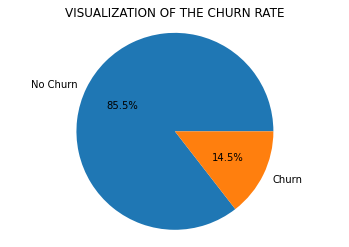

In [124]:
# Visualizing the churn rate
visualize_churn_rate(df)

From the chart shown above, there are more samples for customers without churn than for customers with churn. 
Therefore, there is a class imbalance for the target variable. This class imbalance could lead to predictive models which are biased towards the majority, i.e no churn. 

## The Predictor Variables

The predictors available to us are:
state, account length, area code, international plan, voice mail plan, number vmail messages, total day minutes, total dat calls, total day charge, total eve minutes, total eve calls, total eve charge, total night minutes, total night calls, total night charge, total intl minutes, total intl calls, total intl charge and customer service charge

# DATA PREPARATION

## Detecting and Dealing with missing values

In [102]:
#Checking for null and misssing values
print("There are", df.isnull().values.sum(), "missing values in the dataset")

There are 0 missing values in the dataset


## Data type conversions

In [103]:
# A function that converts target variables that are of string data type to integers

def encode_categorical_columns(df, column_names):
    for column in column_names:
        df[column] = df[column].apply(lambda x: 0 if x == "no" else 1)

In [104]:
# Converting columns 'international plan' and 'voice mail plan' to 1s and 0s
encode_categorical_columns(df, ["international plan", "voice mail plan"])

In [105]:
# Funtion that converts categorical data to numeric through LabelEncoding
from sklearn.preprocessing import LabelEncoder

def encode_categorical_column(dataframe, column_name):
    label_encoder = LabelEncoder()
    dataframe[column_name] = label_encoder.fit_transform(dataframe[column_name])

In [106]:
# Applying LabelEncoder to the column "state"
encode_categorical_column(df, 'state')

## Checking for duplicate values

In [107]:
# A function that checks for duplicate values in a column
def count_duplicates(df, column_name):
    duplicate_count = df.duplicated(subset=column_name).sum()
    return duplicate_count

The phone number is a unique identifier and therefore, it should only contain unique entries

In [108]:
# checking for duplicates in the "phone number" column
duplicate_count = count_duplicates(df, "phone number")
print("There are", duplicate_count, "duplicate values in the phone number column")

There are 0 duplicate values in the phone number column


## Exploratory data analysis

### Univariate anaysis

In [109]:
# Statistical overview of the data
df.describe()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,26.059406,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,14.824911,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,0.000000,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,26.000000,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,39.000000,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,50.000000,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Creating some graphs to visualize the figures in the table above

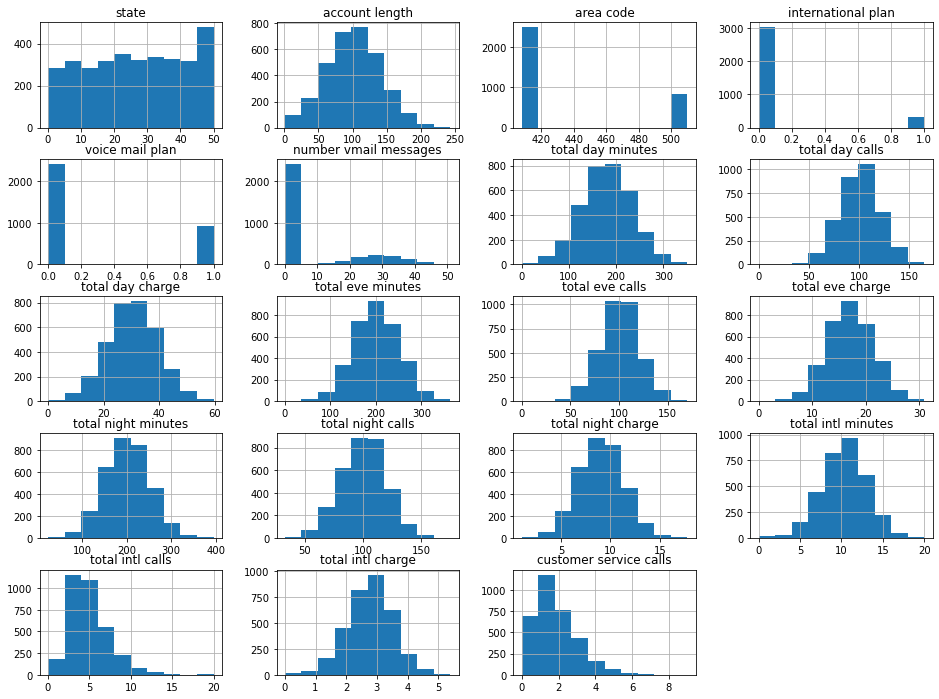

In [110]:
# distribution of features
df.drop(columns='churn').hist(figsize=(16,12));

From the plots displayed above:

1. The scale used across the features is different. Therefore, scaling techniques will be applied to ensure eqaul treatment of features during model training.
2. Features such as 'total intl calls', 'customer service calls'are not normally distributed. They will be normalized


### Multivariate analysis

#### Checking for correlation

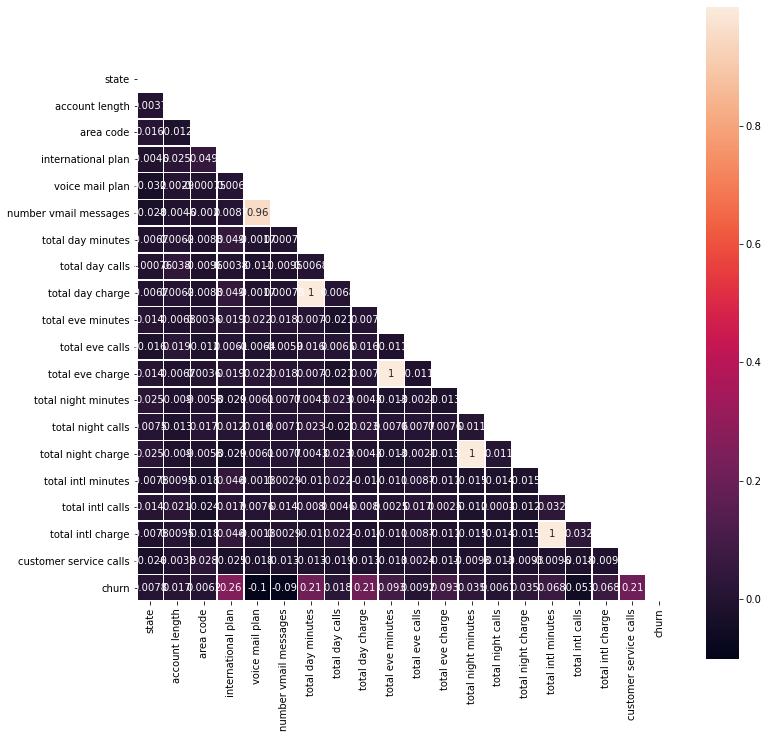

In [111]:
# Plotting a heatmap
fig, ax = plt.subplots(figsize=(12,12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), linewidths=0.5, mask=mask, square=True, ax=ax, annot=True);

From the heatmap above:

1. There is a very low correlation between most features. 
2. Five pairs show high correlation. These are:
- Voice mail messages and voice mail plan (0.96)
- Total day charge and total day minutes (1)
- Total evening charge and total evening minutes (1)
- Total night charge and total night minutes (1)
- Total international charge and total international minutes (1)

These pairs of features display multicollinearity


The correlations can be explained by:
The charges are proportional to the number of minutes the customer spends on a call. Therefore, these charges depend on the number of minutes a customer spends on a call and therefore, they can be dropped

In [112]:
# dropping columns
df.drop(columns = ['total day charge', 'total eve charge', 'total night charge', 'total intl charge'], inplace = True)


# Modeling

The project is a binary classifier task. To solve this problem, the models that will be tried are:
1. Logistic regression
2. K-Nearest Neighbours
3. Decision Trees
4. Random Forest
5. Support Vector Machine

### Train-test split

In [116]:
# Defining y and X vairables
y = df['churn']
X = df.drop(columns=['churn', 'phone number'])

# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [117]:
# preview of X_train
X_train.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls
1066,16,117,510,0,1,25,216.0,140,224.1,69,267.9,112,11.8,4,0
1553,5,86,415,0,0,0,217.8,93,214.7,95,228.7,70,11.3,7,0
2628,42,37,415,0,0,0,221.0,126,204.5,110,118.0,98,6.8,3,4
882,9,130,415,0,0,0,162.8,113,290.3,111,114.9,140,7.2,3,1
984,33,77,415,0,0,0,142.3,112,306.3,111,196.5,82,9.9,1,1


## Handling the class imbalance problem

To handle the class imbalance problem, SMOTE (Synthetic Minority Over-sampling Techtique) is used.

A ratio of 1 is used to balnce the number of true and false statements

In [121]:
# Applying Synthetic Minority Over sampling technique to the datat
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 


In [140]:
# pie chart showing distribution of target variables before and after SMOTE:


def plot_churn_distribution(df, y_train_resampled):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # First pie chart
    churn_counts = df['churn'].value_counts()
    labels = ['No Churn', 'Churn']
    values = churn_counts.values
    ax1.pie(values, labels=labels, autopct="%1.1f%%")
    ax1.set_title('Churn Rate before SMOTE')

    # Second pie chart
    churn_counts1 = y_train_resampled.value_counts()
    labels1 = ['No Churn', 'Churn']
    values1 = churn_counts1.values
    ax2.pie(values1, labels = labels1, autopct = '%.2f')
    ax2.set_title('Churn rate after SMOTE on training set')


    plt.tight_layout()
    plt.show()



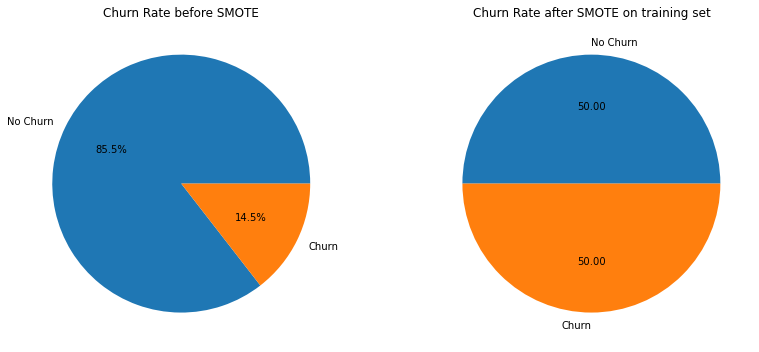

In [145]:
plot_churn_distribution(df, y_train_resampled, 'Churn Rate before SMOTE', 'Churn Rate after SMOTE on training set' )

Checking distribution on test data to ensure SMOTE was not applied

In [148]:
def plot_y_test_distribution(y_test):
    churn_counts = y_test.value_counts()
    labels = ['No Churn', 'Churn']
    values = churn_counts.values

    # Replace True with 'Churn' and False with 'No Churn'
    labels = ['No Churn' if label == False else 'Churn' for label in labels]

    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title('Churn Distribution in y_test')
    plt.axis('equal')
    plt.show()

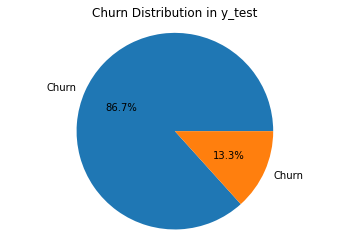

In [149]:
plot_y_test_distribution(y_test)

The testing set therefore maintained an accurate distribution of the sample dataset

## Creating the base Model

### Logistic regression is used to create the base model

In order to address the scaling problem, a pipeline that consists of two steps was created. these steps are:
- Scaling using 'StandardScaler' 
- Logistic regression using 'LogisticRegression'


In [159]:
# A function of a pipeline that creates a linear regression model after standardizing the features
def train_logistic_regression(X_train_resampled, y_train_resampled):
    pipe_log = Pipeline(steps=[('scale', StandardScaler()), ('logreg', LogisticRegression(fit_intercept=False, solver='liblinear'))])
    pipe_log.fit(X_train_resampled, y_train_resampled)
    return pipe_log

In [160]:
logistic_regresssion_model = train_logistic_regression(X_train_resampled, y_train_resampled)

In [164]:
# Defining a function that evaluates the performance of the model
def evaluate(model, X_test, y_test):
    y_train_preds = model.predict(X_train_resampled)
    y_test_preds = model.predict(X_test)
    print('Recall_score: ')
    print('Train: ', recall_score(y_train_resampled, y_train_preds))
    print('Test: ', recall_score(y_test, y_test_preds))
    print('\nPrecision_score: ')
    print('Train: ', precision_score(y_train_resampled, y_train_preds))
    print('Test: ', precision_score(y_test, y_test_preds))
    print('\nAccuracy_score: ')
    print('Train: ', accuracy_score(y_train_resampled, y_train_preds))
    print('Test: ', accuracy_score(y_test, y_test_preds))

    cm = confusion_matrix(y_test, y_test_preds, labels=model.classes_)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    
    disp.plot();

Recall_score: 
Train:  0.7860836859426422
Test:  0.7297297297297297

Precision_score: 
Train:  0.7339771729587358
Test:  0.29136690647482016

Accuracy_score: 
Train:  0.7505876821814763
Test:  0.7278177458033573


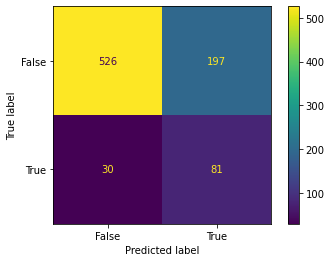

In [165]:
# Evaluating the performance of the model
evaluate(pipe_log, X_test, y_test)

From the results displayed above:

1. The metrics displayed by the Recall score, the Precision score and the Accuracy score are higher in all instances for the Training set compared to the Testing set.
- This shows that the model is overfitting.
2. From the Confusion Matrix:
- The False negatives are 197. This shows that the model is predicting a higher churn rate than is actually true, and therefore is performing poorly


To improve the predictions, Different other types of models were created. These include:
1. KNN (K Nearest Neigbours)
2. Decision Trees
3. Random Forest
4. Support Vector Machine

### K Nearest Neigbours Model

In [167]:
# A function of a pipeline that creates a KNN model after standardizing the features
pipe_knn = Pipeline([
    ('scale', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# Fitting the pipeline to the resampled training data
pipe_knn.fit(X_train_resampled, y_train_resampled)



Pipeline(steps=[('scale', StandardScaler()), ('clf', KNeighborsClassifier())])

Recall_score: 
Train:  0.9797837329572168
Test:  0.6306306306306306

Precision_score: 
Train:  0.872331519464211
Test:  0.2928870292887029

Accuracy_score: 
Train:  0.918194640338505
Test:  0.7482014388489209


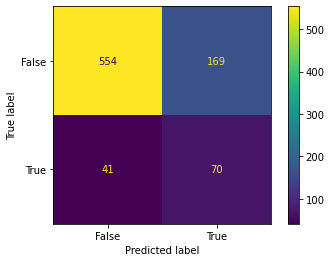

In [168]:
# evaluating the performance of the model
evaluate(pipe_knn, X_test, y_test)

### Decision Tree Model

In [169]:
# A function of a pipeline that creates a Decision Tree model after standardizing the features
pipe_dt = Pipeline(steps=[('scale', StandardScaler()), ('clf', DecisionTreeClassifier(criterion='entropy', random_state=42))])
pipe_dt.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scale', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])

Recall_score: 
Train:  1.0
Test:  0.7567567567567568

Precision_score: 
Train:  1.0
Test:  0.48554913294797686

Accuracy_score: 
Train:  1.0
Test:  0.8609112709832134


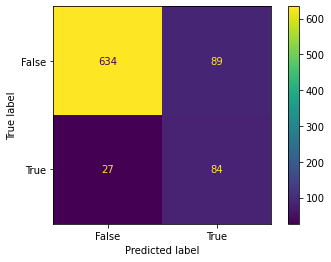

In [170]:
# evaluate the performance of the model
evaluate(pipe_dt, X_test, y_test)

The decision tree model has a higher performance compared to the baseline model. However, the model is overfitting.

In [ ]:
# checking the pipeline steps to note model position
pipe_dt.steps

[('scale', StandardScaler()),
 ('clf', DecisionTreeClassifier(criterion='entropy', random_state=42))]

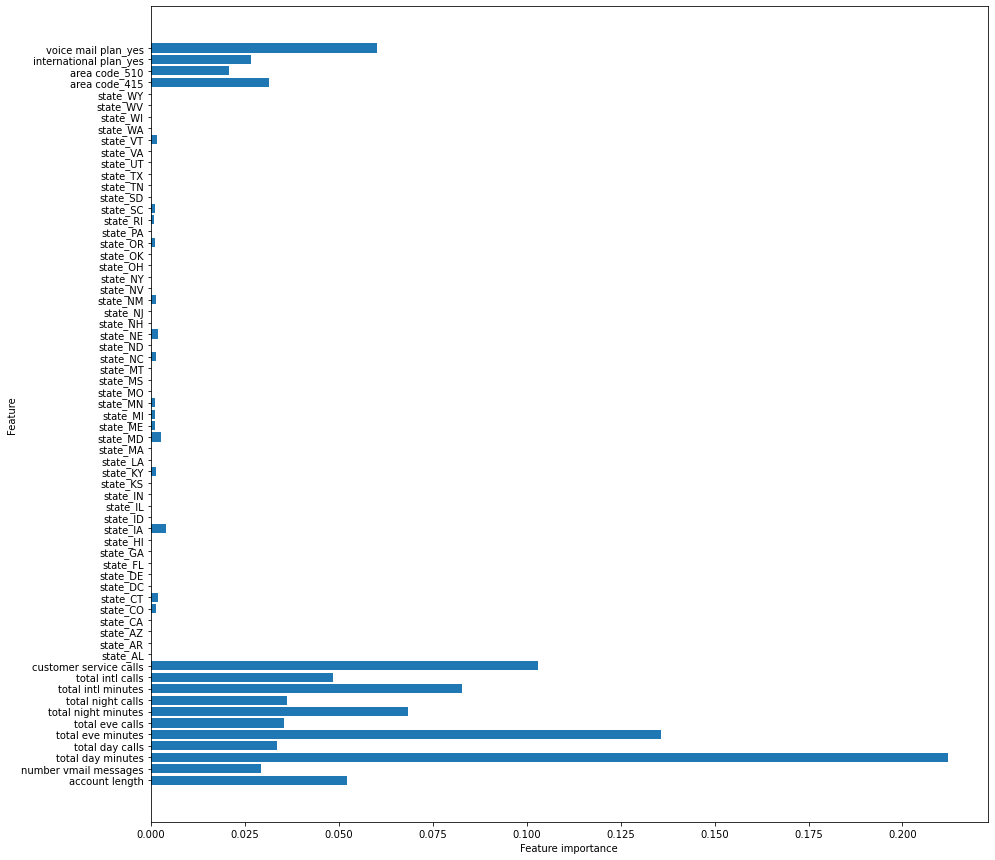

In [ ]:
# function to plot feature importances
def plot_feature_importances(pipe, figsize):
    model = pipe.steps[1][1]
    plt.figure(figsize=figsize)
    plt.barh(X_train_resampled.columns, model.feature_importances_, align='center') 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(pipe_dt, (15,15))

total day minutes is an important factor in determining whether a customer would churn or not, followed by total evening minutes and customer service calls. State has the least importance in predicting customer churn.

### Feature selection

Recursive feature elimination with cross-validation is used to select a subset of features relevant for model construction. 

In [ ]:
# feature selection using RFECV
rfecv = RFECV(estimator=DecisionTreeClassifier(random_state=42), scoring='recall')
pipe_dt2 = Pipeline(steps=[('scale', StandardScaler()), ('Feature Selection', rfecv), ('clf', DecisionTreeClassifier(random_state=42))])
pipe_dt2.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scale', StandardScaler()),
                ('Feature Selection',
                 RFECV(estimator=DecisionTreeClassifier(random_state=42),
                       scoring='recall')),
                ('clf', DecisionTreeClassifier(random_state=42))])

In [ ]:
# optimal number of features selected via cross-validation
print(f'Optimal number of features: {rfecv.n_features_}' )

Optimal number of features: 15


Out of the 65 features, there are 15 optimal features <br>
The selected features are shown below:

In [ ]:
# selected features (assigned a rank of 1)
rfecv_df = pd.DataFrame(rfecv.ranking_,index=X_train_resampled.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df[rfecv_df['Rank'] == 1]

,Rank
account length,1
area code_510,1
area code_415,1
international plan_yes,1
customer service calls,1
total intl calls,1
total intl minutes,1
voice mail plan_yes,1
total night minutes,1
total eve calls,1


In [ ]:
# remove columns that are not part of the optimal features
cols = rfecv_df[rfecv_df['Rank'] == 1].index
X_train_resampled = X_train_resampled[cols]
X_test = X_test[cols]
X_train_resampled.head(2)

,account length,area code_510,area code_415,international plan_yes,customer service calls,total intl calls,total intl minutes,voice mail plan_yes,total night minutes,total eve calls,total eve minutes,number vmail messages,total day minutes,total day calls,total night calls
0,117,1,0,0,0,4,11.8,1,267.9,69,224.1,25,216.0,140,112
1,86,0,1,0,0,7,11.3,0,228.7,95,214.7,0,217.8,93,70


### Hyperparameter tuning of the decision tree model

The hyperparameters of the decision tree including max_depth, min_samples_leaf, min_samples_split can be tuned to early stop the growth of the tree and prevent the model from overfitting.

In [ ]:
# hyperparameter tuning using GridSearchCV
params_dt = {'clf__criterion': ['gini', 'entropy'],
             'clf__max_depth': range(14, 32, 2),
             'clf__min_samples_split' : range(2, 10, 2),
             'clf__min_samples_leaf': [2, 3, 5, 7, 10],
             'clf__max_features': [11, 13, 15]
}

gridsearch_dt = GridSearchCV(pipe_dt, params_dt, cv=4, scoring='recall')
gridsearch_dt.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               random_state=42))]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': range(14, 32, 2),
                         'clf__max_features': [11, 13, 15],
                         'clf__min_samples_leaf': [2, 3, 5, 7, 10],
                         'clf__min_samples_split': range(2, 10, 2)},
             scoring='recall')

In [ ]:
# parameters that gave the best result
print(f'Optimal parameters: {gridsearch_dt.best_params_}')

# Mean cross-validated score of the best_estimator
print(f'Validation recall: {gridsearch_dt.best_score_}')

Optimal parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 28, 'clf__max_features': 15, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Validation recall: 0.8725937371677781


Recall_score: 
Train:  0.9811941701927598
Test:  0.7927927927927928

Precision_score: 
Train:  0.9971333014811276
Test:  0.5238095238095238

Accuracy_score: 
Train:  0.9891866478608369
Test:  0.8764988009592326


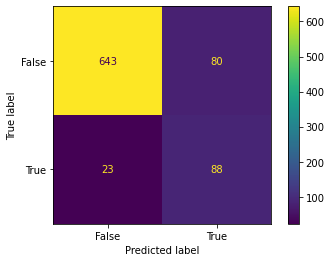

In [ ]:
# evaluate the performance of the model
evaluate(gridsearch_dt, X_test, y_test)

On tuning the model, the model is performing better based on the recall score. However, the precision score is slightly low. There is a decrease in the difference between the train scores and the test scores(overfitting reduced).

### Random forest

Random forest is used since it is naturally resistant to noise and variance.

In [ ]:
# create a pipeline
pipe_rf = Pipeline(steps=[('scale', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))])
pipe_rf.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scale', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

Recall_score: 
Train:  1.0
Test:  0.6666666666666666

Precision_score: 
Train:  1.0
Test:  0.6851851851851852

Accuracy_score: 
Train:  1.0
Test:  0.9148681055155875


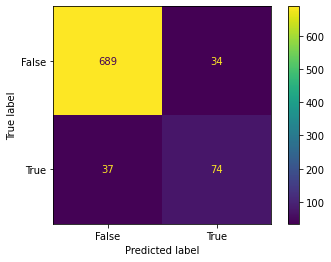

In [ ]:
# evaluate model performance
evaluate(pipe_rf, X_test, y_test)

The random forest model has a higher recall compared to the baseline logistic regression model, but a lower recall compared to the decision tree model. <br>
The model is overfitting.

### Hyperparameter tuning of the random forest model

There are some parameters of random forest that can be tuned for the model’s better performance. This includes n_estimators, max_depth, min_samples_split, min_samples_leaf and max_features.

In [ ]:
# hyperparameter tuning using GridSearchCV
params_rf = {'rf__n_estimators': range(400, 800, 200),
             'rf__criterion': ['gini', 'entropy'],
             'rf__max_depth': range(14, 20, 2),
             'rf__min_samples_split': range(3, 4, 7),
             'rf__min_samples_leaf': [5, 7, 12]
             
}

gridsearch_rf = GridSearchCV(pipe_rf, params_rf, cv=4, scoring='recall')
gridsearch_rf.fit(X_train_resampled, y_train_resampled)


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': range(14, 20, 2),
                         'rf__min_samples_leaf': [5, 7, 12],
                         'rf__min_samples_split': range(3, 4, 7),
                         'rf__n_estimators': range(400, 800, 200)},
             scoring='recall')

In [ ]:
# parameters that gave the best result
print(f'Optimal parameters: {gridsearch_rf.best_params_}')

# Mean cross-validated score of the best_estimator
print(f'Validation recall: {gridsearch_rf.best_score_}')

Optimal parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 18, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 3, 'rf__n_estimators': 600}
Validation recall: 0.8702494229925095


Recall_score: 
Train:  0.9619181946403385
Test:  0.6756756756756757

Precision_score: 
Train:  0.9898403483309144
Test:  0.6696428571428571

Accuracy_score: 
Train:  0.9760225669957687
Test:  0.9124700239808153


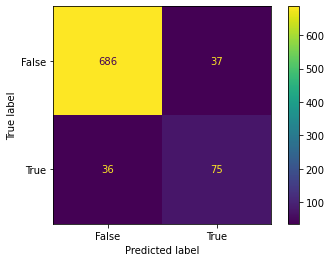

In [ ]:
# evaluate the performance of the model
evaluate(gridsearch_rf, X_test, y_test)

On hyperparameter tuning, the recall increases by 1%. The model utilizes high computational power yet it performs poorly. Its performance is lower than the performance of the decision tree model.

## Model evaluation

Decision tree with tuned hyperparameters is the model with the best performance. The optimal parameters of the tuned model are: {'clf__criterion': 'entropy', 'clf__max_depth': 28, 'clf__max_features': 15, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}<br>
The model has the highest recall score. The accuracy and precision scores are above average. <br>
However, the recall score achieved is below the set score of at least 85%.<br>
The evaluation metric values of the tuned decision tree are shown below:

In [ ]:
# evaluation metrics of the best model based on the test data
print('DECISION TREE(TUNED) SCORES:')
print('Test Recall score: ', recall_score(y_test, gridsearch_dt.predict(X_test)))
print('Test Precision score: ', precision_score(y_test, gridsearch_dt.predict(X_test)))
print('Test Accuracy score: ', accuracy_score(y_test, gridsearch_dt.predict(X_test)))

DECISION TREE(TUNED) SCORES:
Test Recall score:  0.7927927927927928
Test Precision score:  0.5238095238095238
Test Accuracy score:  0.8764988009592326


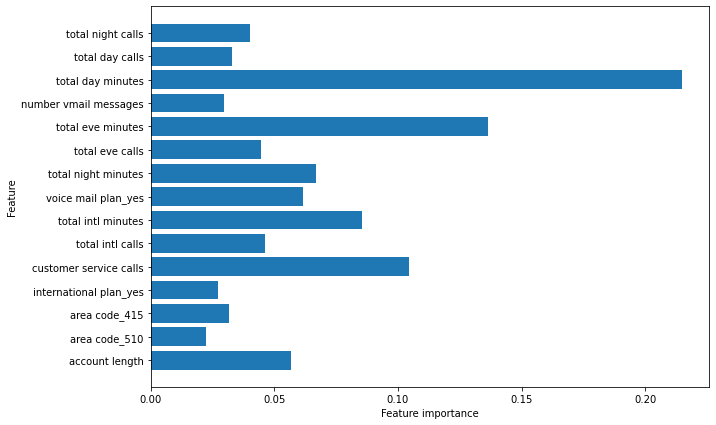

In [ ]:
# plot feature importances of the best model using the defined function
# function takes in the pipeline name and figsize.
plot_feature_importances(gridsearch_dt.best_estimator_, (10,7))

## Conclusions and recommendations

The final model that will be used to predict customer churn is the decision tree with tuned hyperparameters.This model results in the lowest number of false negatives.<br>
The most important features for predicting customer churn are:
- total day minutes: total number of minutes the customer has been in calls during the day
- total evening minutes: total number of minutes the customer has been in calls during the evening
- customer service calls: number of calls the customer has made to customer service
- total international minutes: total number of minutes the user has been in international calls
 
Syriatel should ensure effective customer service so as to meet customers' expectations and analyze customer interactions. They can then follow up on both positive and negative feedbacks received.<br>
The more the number of minutes the customer spends on the phone, the higher the likelihood of not churning.  The company should look into the call charge rates in comparison to the competitors, and  consider if they should lower the charges of calls per minute. This can prevent other customers from churning.

## Next steps

The targeted recall score of 85% is not achieved by the best performing model. There is still some overfitting in the model irregardless of hyperparameter tuning.<br>
The training data size should be increased to reduce overfitting and hence improve model performance.